# Simulating ODE Models with SBMLImporter in Julia

This document details how to simulate dynamic Ordinary Differential Equation (ODE) model when the model is provided in the SBML standard format, as well as how to evaluate different ODE solvers for an imported model.

## Setup

The packages needed are:

- **SBMLImporter.jl** and **Catalyst.jl**: For importing SBML models.
- **OrdinaryDiffEq.jl**: For simulating ODE models.
- **Plots.jl** and **StatsPlots.jl**: For visualizing simulation results.


In [64]:
using SBMLImporter, Catalyst, OrdinaryDiffEq, Plots, StatsPlots

## Importing and simulating a model

As a case study, we use the [Brusselator](https://en.wikipedia.org/wiki/Brusselator) model. The first step is to parse the model into a [Catalyst](https://github.com/SciML/Catalyst.jl) `ReactionSystem` with `load_SBML`:

In [65]:
path_SBML = joinpath(@__DIR__, "Assets", "brusselator.xml")
prnbng, cb = load_SBML(path_SBML)
nothing

This returns two outputs: a `ParsedReactionSystem` (`prnbng`) and a `CallbackSet` (`cb`). The `ParsedReactionSystem` includes the reaction system (`prnbng.rn`), a map for the initial condition values of each specie (`prnbng.u₀`), and a map setting the model parameter values (`prnbng.p`). The `CallbackSet` holds any potential SBML events. The reaction system can be visualized as:

In [66]:
prnbng.rn

Model New_Model
States (2):
  Y(t)
  X(t)
Parameters (3):
  B
  A
  compartment

And it can now be simulated as an ODE by converting the reaction system (`prnbng.rn`) into an `ODEProblem`:

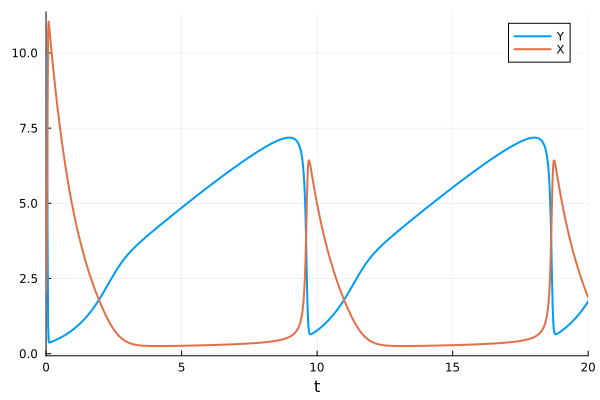

In [67]:
tspan = (0.0, 20.0)
oprob = ODEProblem(prnbng.rn, prnbng.u₀, tspan, prnbng.p)
sol = solve(oprob, Rodas5(), callback=cb)
plot(sol; lw=2)

The order which parameters and species appear in the `ODEProblem` can be accessed by:

In [68]:
specie_names = species(prnbng.rn)
parameter_names = parameters(prnbng.rn)

3-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 B
 A
 compartment

This can be used to, for example, set the value of parameter `B` to 3.0:

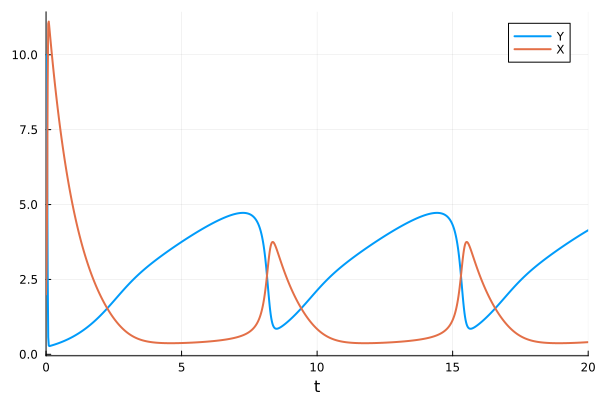

In [69]:
p = oprob.p
p[findfirst(x -> x == "B", string.(parameter_names))] = 3.0
oprob = remake(oprob, p=p)
sol = solve(oprob, Rodas5(), callback=cb)
plot(sol; lw=2)

## Comparing different ODE solvers

Most modeling tasks like exploring model behavior by scanning parameter space, require the ODE model to be simulated multiple times. Hence, using a fast and accurate ODE solver is important.

Accuracy can be evaluated by comparing different solvers against a high-precision solution obtained with low solver tolerances. For example, let us compare the stiff `Rodas5` against the non-stiff `Vern7` solver by first generating a high-accuracy solution using `Rodas4P`:

In [70]:
sol_highacc = solve(oprob, Rodas4P(), callback=cb, abstol=1e-15, reltol=1e-15, saveat=1:0.2:20)
nothing

Here `saveat=1:0.2:20` are the time points at which the solution is saved at. Given this, we can proceed to assess both the accuracy and runtime of the two solvers:

In [71]:
using Printf
sol_rodas5 = solve(oprob, Rodas5(), callback=cb, abstol=1e-8, reltol=1e-8, saveat=1:0.2:20)
sol_vern7 = solve(oprob, Vern7(), callback=cb, abstol=1e-8, reltol=1e-8, saveat=1:0.2:20)
# Squared error
acc_rodas5 = sum((Array(sol_rodas5) - Array(sol_highacc)).^2)
acc_vern7 = sum((Array(sol_vern7) - Array(sol_highacc)).^2)
# Runtime - mean of 5 runs
runtime_rodas5, runtime_vern7 = 0.0, 0.0
for i in 1:5
    runtime_rodas5 += @elapsed _ = solve(oprob, Rodas5(), callback=cb, abstol=1e-8, reltol=1e-8, saveat=1:0.2:20)
    runtime_vern7 += @elapsed _ = solve(oprob, Vern7(), callback=cb, abstol=1e-8, reltol=1e-8, saveat=1:0.2:20)
end

@printf("Rodas5 : runtime = %.2e and accuracy = %.2e\n", runtime_rodas5/5, acc_rodas5)
@printf("Vern7 : runtime = %.2e and accuracy = %.2e\n", runtime_vern7/5, acc_vern7)

Rodas5 : runtime = 1.33e-03 and accuracy = 1.06e-11
Vern7 : runtime = 2.66e-04 and accuracy = 4.70e-13


`Vern7` outperforms `Rodas5` in terms of both speed and accuracy. To further evaluate solvers considering both runtime and accuracy we can use a work-precision diagram. This approach entails to solve the model at different solver tolerances:

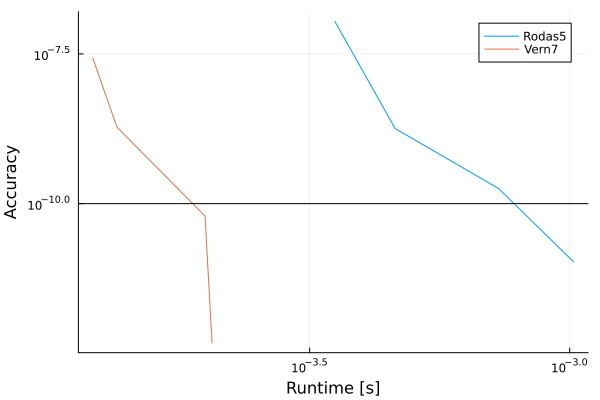

In [72]:
tols = [1e-8, 1e-7, 1e-6, 1e-5]
runtime_rodas5, acc_rodas5 = zeros(4), zeros(4)
runtime_vern7, acc_vern7 = zeros(4), zeros(4)
for (i, tol) in pairs(tols)
    # Get accuracy
    sol_rodas5 = solve(oprob, Rodas5(), callback=cb, abstol=tol, reltol=tol, saveat=1:0.2:20)
    sol_vern7 = solve(oprob, Vern7(), callback=cb, abstol=tol, reltol=tol, saveat=1:0.2:20)
    acc_rodas5[i] = sum((Array(sol_rodas5) - Array(sol_highacc)).^2)
    acc_vern7[i] = sum((Array(sol_vern7) - Array(sol_highacc)).^2)
    # Compute runtime
    for j in 1:10
        runtime_rodas5[i] += @elapsed _ = solve(oprob, Rodas5(), callback=cb, abstol=tol, reltol=tol, saveat=1:0.2:20)
        runtime_vern7[i] += @elapsed _ = solve(oprob, Vern7(), callback=cb, abstol=tol, reltol=tol, saveat=1:0.2:20)
    end
    runtime_rodas5[i] /= 10.0
    runtime_vern7[i] /= 10.0
end

plot(runtime_rodas5, acc_rodas5, xlabel="Runtime [s]", ylabel="Accuracy", label="Rodas5", xaxis=:log10, yaxis=:log10)
plot!(runtime_vern7, acc_vern7, xlabel="Runtime [s]", ylabel="Accuracy", label="Vern7")
hline!([1e-10], color="Black", label=false)

The work-precision diagram demonstrates that at a certain accuracy level, say `1e-10` (horizontal line), `Vern7` achieves the accuracy with less computational time (work) compared to `Rodas5`.

While `Vern7` shows better performance in this instance, it is important to consider the broader context. In systems biology, stiff solvers like `Rodas5` are often more effective due to the models often being stiff ADD. Moreover, the results above are based on a single set of parameter values. In practice, like when exploring model behaviors or conducting other modeling tasks, the model is simulated for many parameter combinations. Hence, for a more realistic benchmark, let us extend our analysis to include a benchmark that assesses the performance of the solvers across 200 random combinations of two model parameters, `A` and `B`:

In [73]:
using Distributions
a_values = rand(Uniform(0, 10.0), 200)
b_values = rand(Uniform(0, 10.0), 200)
c_values = ones(200)
# p[1] = B, p[2] = A, p[3] = compartment (constant)
p = [[b_values[i], a_values[i], c_values[i]] for i in 1:200]
nothing

Here `p` stores all parameter we want to test, e.g. `p[1]` is one of 200 parameter combinations. We can now test runtime and accuracy:

In [74]:
# Function that takes parameter vector p and returns runtime + accuracy.
function get_runtime_accuracy(solver, p, oprob)
    sol_highacc = solve(oprob, Rodas4P(), callback=cb, abstol=1e-15, reltol=1e-15, saveat=1:0.2:20)
    sol = solve(oprob, solver, callback=cb, abstol=1e-8, reltol=1e-8, saveat=1:0.2:20)
    acc = sum((Array(sol) - Array(sol_highacc)).^2)
    runtime = 0.0
    for i in 1:20
        runtime += @elapsed _ = solve(oprob, solver, callback=cb, abstol=1e-8, reltol=1e-8, saveat=1:0.2:20)
    end

    return runtime / 20, acc
end

runtime_rodas5, acc_rodas5 = zeros(200), zeros(200)
runtime_vern7, acc_vern7 = zeros(200), zeros(200)
for (i, _p) in pairs(p)
    runtime_rodas5[i], acc_rodas5[i] = get_runtime_accuracy(Rodas5(), _p, oprob)
    runtime_vern7[i], acc_vern7[i] = get_runtime_accuracy(Vern7(), _p, oprob)
end

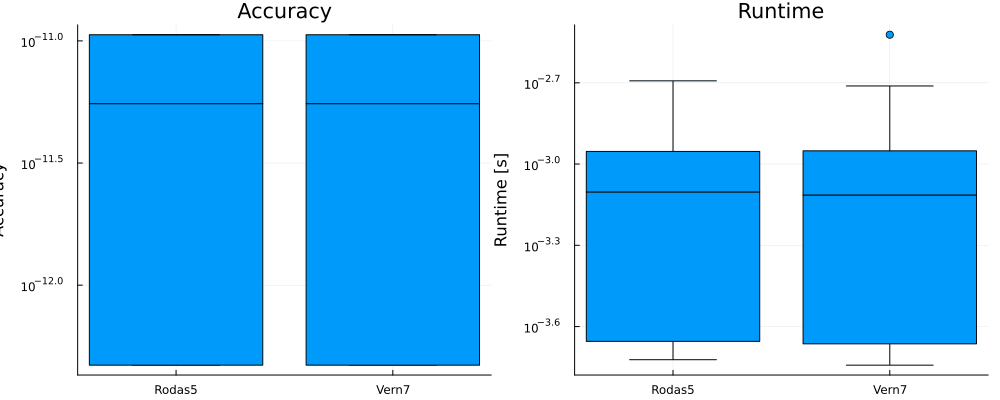

In [75]:
xaxis = repeat(["Rodas5", "Vern7"], outer=200)
p1 = boxplot(xaxis, vcat(acc_rodas5, acc_vern7), ylabel="Accuracy", label=false, title = "Accuracy", yaxis=:log10)
p2 = boxplot(xaxis, vcat(runtime_rodas5, runtime_vern7), ylabel="Runtime [s]", label=false, title = "Runtime", yaxis=:log10)
plot(p1, p2, layout=(1, 2), size=(1000, 400))

When evaluating performance across random parameter combinations, which more accurately reflects typical modeling scenarios, both solvers have comparable performance.

## Next Steps

Since SBMLImporter.jl import models into a Catalyst `ReactionSystem`, thus anything that can be done with a `ReactionSystem` can be done with an imported model. This entails, for example, bifurcation analysis and moment closure analysis for effectively simulate stochastic models. For further exploration we strongly recommend the Catalyst [documentation](https://docs.sciml.ai/Catalyst/stable/).